<a href="https://colab.research.google.com/github/aacalva/Portafolio/blob/main/EMBER_malware_deteccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Importar archivo .json de kaggler creada desde la cuenta personal en kaggler
!gdown --id 1p_qU0xKD_bsfaYJS2KzuHRuuQIeY6Q5p
# Se indica la ubicacion del token
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

# descargamos el dataset
!kaggle datasets download -d edirgarcia/tabular-ember

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1p_qU0xKD_bsfaYJS2KzuHRuuQIeY6Q5p
To: /content/kaggle.json
100% 65.0/65.0 [00:00<00:00, 229kB/s]
Dataset URL: https://www.kaggle.com/datasets/edirgarcia/tabular-ember
License(s): GNU Affero General Public License 3.0
tabular-ember.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip tabular-ember.zip

Archive:  tabular-ember.zip
replace train_features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data=pd.read_csv('/content/train_features.csv')
print(data)

<ipython-input-6-87d29a3063ab>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('/content/train_features.csv')


        Unnamed: 0                                             sha256  \
0                0  0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...   
1                1  c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...   
2                2  eac8ddb4970f8af985742973d6f0e06902d42a3684d791...   
3                3  7f513818bcc276c531af2e641c597744da807e21cc1160...   
4                4  ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...   
...            ...                                                ...   
799995      799995  68f325a3cce1ab28fa49a856c73bc3ce192073a6fdd8c0...   
799996      799996  a75eacd3e4e90c891da6be58ec7838f2d621e4c048ebfc...   
799997      799997  652b9130302d33a370c2d26de42cb4983af7bfc286215b...   
799998      799998  6984c895dda5a0c02657b00d6993147a4f0a13c65a85db...   
799999      799999  f16ecf10906fcb01b635c562278088f620c1fab6eb1a96...   

                                     md5 appeared  label avclass  \
0       63956d6417f8f43357d9a8e79e52257e  2006-12      

In [1]:
# Sirve para encontrar columnas que tienen valores NaN
columna_vacia = data.columns[data.isnull().any()]
print(columna_vacia)


NameError: name 'data' is not defined

**Preprocesamiento de datos**

In [ ]:
label_encoder=LabelEncoder()
data['avclass']=label_encoder.fit_transform(data['avclass'])
data['entry']=label_encoder.fit_transform(data['entry'])
data['imports']=label_encoder.fit_transform(data['imports'])
data['coff.characteristics']=label_encoder.fit_transform(data['coff.characteristics'])
data['appeared']=label_encoder.fit_transform(data['appeared'])
# convertimos los -1 de label en 1 ya que igual son amenazas
data.loc[data['label'] == -1, 'label'] = 1

print(data)

        Unnamed: 0                                             sha256  \
0                0  0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...   
1                1  c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...   
2                2  eac8ddb4970f8af985742973d6f0e06902d42a3684d791...   
3                3  7f513818bcc276c531af2e641c597744da807e21cc1160...   
4                4  ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...   
...            ...                                                ...   
799995      799995  68f325a3cce1ab28fa49a856c73bc3ce192073a6fdd8c0...   
799996      799996  a75eacd3e4e90c891da6be58ec7838f2d621e4c048ebfc...   
799997      799997  652b9130302d33a370c2d26de42cb4983af7bfc286215b...   
799998      799998  6984c895dda5a0c02657b00d6993147a4f0a13c65a85db...   
799999      799999  f16ecf10906fcb01b635c562278088f620c1fab6eb1a96...   

                                     md5  appeared  label  avclass  \
0       63956d6417f8f43357d9a8e79e52257e         0   

In [ ]:
# Seleccionar características relevantes
caracteristicas = ['appeared', 'avclass', 'entry',
                   'imports', 'coff.characteristics']

# Extraer características y etiquetas
X = data[caracteristicas]
y = data['label']
# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Definir el modelo
model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='softplus'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(180, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con regularización L2

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Definir callbacks para guardar el mejor modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Entrenar el modelo
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
16000/16000 [==============================] - 167s 10ms/step - loss: 0.6654 - accuracy: 0.6231 - val_loss: 0.6619 - val_accuracy: 0.6244
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16000/16000 [==============================] - 147s 9ms/step - loss: 0.6618 - accuracy: 0.6252 - val_loss: 0.6619 - val_accuracy: 0.6244
Epoch 3/50
16000/16000 [==============================] - 141s 9ms/step - loss: 0.6616 - accuracy: 0.6253 - val_loss: 0.6619 - val_accuracy: 0.6244
Epoch 4/50
16000/16000 [==============================] - 133s 8ms/step - loss: 0.6615 - accuracy: 0.6253 - val_loss: 0.6619 - val_accuracy: 0.6244
Epoch 5/50
16000/16000 [==============================] - 136s 8ms/step - loss: 0.6615 - accuracy: 0.6253 - val_loss: 0.6619 - val_accuracy: 0.6244
Epoch 6/50
16000/16000 [==============================] - 152s 9ms/step - loss: 0.6615 - accuracy: 0.6253 - val_loss: 0.6619 - val_accuracy: 0.6244
Epoch 7/50
16000/16000 [==============================] - 152s 9ms/step - loss: 0.6615 - accuracy: 0.6253 - val_loss: 0.6619 - val_accuracy: 0.6244
Epoch 8/50
16000/16000 [==============================] - 141s 9ms/step - loss: 0.6615 - accuracy: 0.6253 - val_loss: 0.661

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 300)               1800      
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               38528     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)              

In [ ]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Realizar predicciones
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

5000/5000 [==============================] - 18s 4ms/step - loss: 0.6618 - accuracy: 0.6246
Loss: 0.6617587804794312, Accuracy: 0.624625027179718
5000/5000 [==============================] - 15s 3ms/step


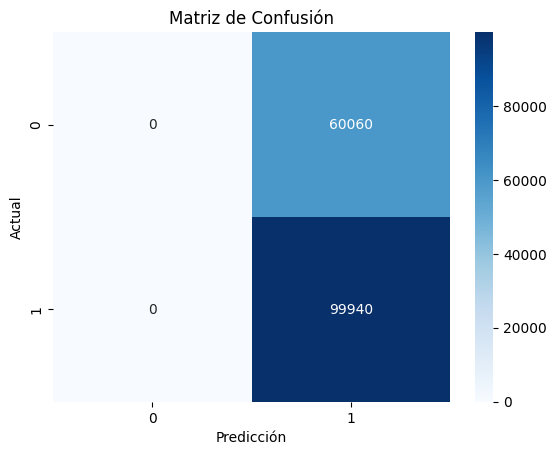

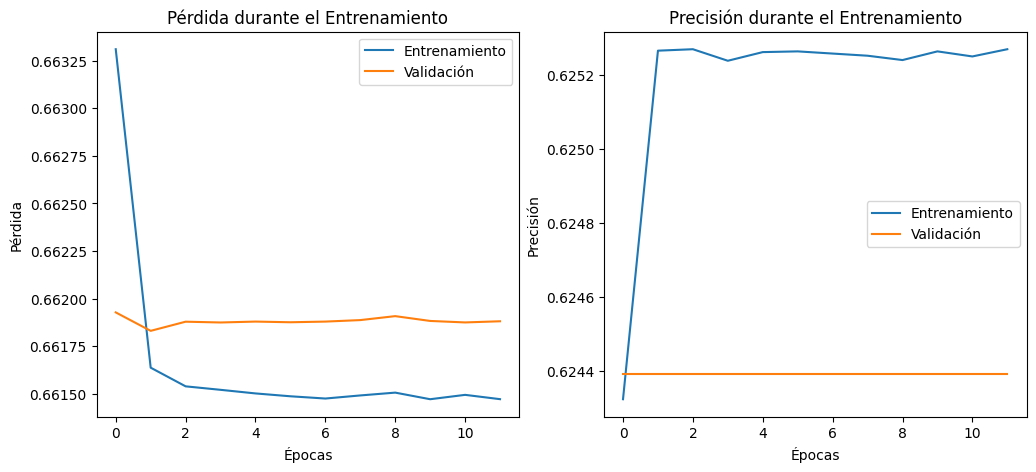

In [ ]:

# Make predictions on the test set
#y_pred = model.predict(X_test)
#y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

# ... (rest of your code)
# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()